In [1]:
import autograd
import autograd.numpy as np
import math

In [2]:
class robust_LR:
    '''
        Consider the robust linear regression problem.
        
        f(x) = 1 / n sum(l(b_i - a_i^T x)), where l(x) = log(x^2/2 + 1)
    '''
    def __init__(self, data):
        # data structure is 2d narray, where each row is one data point and the last column is the label
        self.data = data
        self.n = data.shape[0]
        self.dim = data.shape[1] - 1
        self.A = data[:, :-1]
        self.b = data[:, -1:]
        
    def func_value(self, x):
        n = self.n
        A = self.A
        b = self.b
        sum_loss = 0
        for i in range(n):
            a_i = A[i, :]
            b_i = b[i, :]
            y_i = b_i - np.dot(a_i, x)
            sum_loss = sum_loss + np.log(y_i**2 / 2 + 1)
        return sum_loss / n
    
    def full_gradient(self, x):
        dfdx = autograd.grad(self.func_value)
        return dfdx(x)
    
    def sample_gradient(self, x_eval):
        n = self.n
        A = self.A
        b = self.b
        gradient_list = []
        for i in range(n):
            a_i = A[i, :]
            b_i = b[i, :]
            sample_loss = lambda x: np.log((b_i - np.dot(a_i, x))**2 / 2 + 1)
            gradient_i = autograd.grad(sample_loss)
            gradient_i_eval = gradient_i(x_eval)
            gradient_list.append(gradient_i_eval)
            
        return gradient_list
    
    def batch_gradient(self, x, batch_size):
        '''
            return the list of mini-batch gradients evaluated at point x with the batch-size = batch_size
        '''
        n = self.n
        gradient_list = self.sample_gradient(x)
        all_gradients = np.asarray(gradient_list)
        # generate shuffled data
        permutation = list(np.random.permutation(self.n))
        shuffled_gradients = all_gradients[permutation, :]
        
        num_batches = math.floor(self.n / batch_size)
        
        mini_batches = []
        for i in range(num_batches):
            mini_batch_grad = shuffled_gradients[i * batch_size:(i + 1) * batch_size, :]
            mini_batches.append(mini_batch_grad)
            
        if n % batch_size != 0:
            mini_batches.append(shuffled_gradient[num_batches * batch_size:, :])
            
        return mini_batches
    
    def minibatch_grad(self, x_eval, batch_size, batch_i):
        # return the mini-batch gradient evaluated at x_eval with the i-th batch
        n = self.n
        all_gradients = np.asarray(self.sample_gradient(x_eval))
        
        batch_grad = all_gradients[batch_i * batch_size:(batch_i + 1) * batch_size, :]
        curr_minibatch_grad = np.sum(batch_grad, axis=0) / batch_grad.shape[0]
        return curr_minibatch_grad

In [76]:
def SL_BFGS(H_prev, curr_batch_grad, prev_batch_grad, x_curr, x_prev, q, w):
    '''
        Generate positive definite H matrices
        Hyperparameters: 
                q is some scalar in (0, 1)
                w is some positive scalar
    '''
    dim = H_prev.shape[0]
    y = curr_batch_grad - prev_batch_grad
    s = x_curr - x_prev
    B_prev = np.linalg.inv(H_prev)
    s_B_prev_s = np.dot(np.dot(B_prev, s), s)
    
    if np.dot(s, y) < q * s_B_prev_s:
        theta = (1 - q) * s_B_prev_s / (s_B_prev_s - np.dot(s, y))
    else:
        theta = 1
    
    y_bar = w * (theta * y + (1 - theta) * np.dot(B_prev, s))
    rho = 1 / np.dot(s, y_bar)
    s_2d = s[:, np.newaxis]
    y_bar_2d = y_bar[:, np.newaxis]
    
    H = np.dot(np.dot(np.eye(dim) - rho * np.dot(s_2d, y_bar_2d.T), H_prev), np.eye(dim) - rho * np.dot(y_bar_2d, s_2d.T)) + rho * np.dot(s_2d, s_2d.T)
    
    return H
    
        

In [77]:
def clipped_SQN(objFunc, x_start, H_start, batch_S1, batch_S2, K, r, L_0, L_1, epsilon, h_c, lambda_M):
    '''
        Implementation of Clipped Stochastic Quasi-Newton method
    '''
    n = objFunc.n
    
    num_batches_S1 = math.ceil(n / batch_S1)
    num_batches_S2 = math.ceil(n / batch_S2)
    
    x = np.copy(x_start)
    x_prev = np.copy(x)
    v = 0
    H = np.copy(H_start)
    
    
    batch_S1_count = 0
    batch_S2_count = 0
    
    x_trajectory = [x]
    loss_traj = [objFunc.func_value(x)]
    for k in range(K):
        if k % r == 0:
            current_grad = objFunc.minibatch_grad(x, batch_S1, batch_S1_count % num_batches_S1)
            prev_grad = objFunc.minibatch_grad(x_prev, batch_S1, batch_S1_count % num_batches_S1)
            v = current_grad
            batch_S1_count = batch_S1_count + 1
        else:
            current_grad = objFunc.minibatch_grad(x, batch_S2, batch_S2_count % num_batches_S2)
            prev_grad = objFunc.minibatch_grad(x_prev, batch_S2, batch_S2_count % num_batches_S2)
            v = v + current_grad - prev_grad
            batch_S2_count += 1
        
        x_prev = np.copy(x)
        h_c_bar = h_c / (lambda_M ** 2)
        v_norm = np.linalg.norm(v)
        eta_choice = h_c_bar * np.array([1 / (2 * L_0), epsilon / (L_0 * v_norm), epsilon / (L_1 * v_norm**2)])
        eta = np.min(eta_choice)
        x = x - eta * np.dot(H, v)
        H = SL_BFGS(H, current_grad, prev_grad, x, x_prev, 0.5, 1.0)
        x_trajectory.append(x)
        loss_traj.append(objFunc.func_value(x))
    return x_trajectory, loss_traj

In [163]:
def SQN(objFunc, x_start, H_start, batch_size, K, L, lambda_m, lambda_M, epsilon):
    '''
        Implementation of Stochastic Quasi-Newton method
    '''
    n = objFunc.n
    num_batches = math.ceil(n / batch_size)
    
    x = np.copy(x_start)
    x_prev = np.copy(x_start)
    H = np.copy(H_start)
    
    batch_count = 0
    x_trajectory = [x]
    loss_traj = [objFunc.func_value(x)]
    
    for k in range(K):
        curr_grad = objFunc.minibatch_grad(x, batch_size, batch_count % num_batches)
        prev_grad = objFunc.minibatch_grad(x_prev, batch_size, batch_count % num_batches)
        batch_count += 1
        
        x_prev = np.copy(x)
        eta = epsilon * lambda_m / ( L * lambda_M**2)
        x = x - eta * np.dot(H, x)
        H = SL_BFGS(H, curr_grad, prev_grad, x, x_prev, 0.5, 1.0)
        x_trajectory.append(x)
        loss_traj.append(objFunc.func_value(x))
        
    return x_trajectory, loss_traj
        

In [79]:
def minibatch_SGD(objFunc, x_start, batch_size, K, L, epsilon):
    '''
        Implementation of mini-batch Stochastic Gradient Descent
    '''
    n = objFunc.n
    num_batches = math.ceil(n / batch_size)
    batch_count = 0
    
    x = np.copy(x_start)
    
    x_trajectory = [x]
    loss_traj = [objFunc.func_value(x)]
    
    for k in range(K):
        curr_grad = objFunc.minibatch_grad(x, batch_size, batch_count % num_batches)
        eta = epsilon / L
        x = x - eta * curr_grad
        x_trajectory.append(x)
        loss_traj.append(objFunc.func_value(x))
        
    return x_trajectory, loss_traj

In [80]:
def Spider(objFunc, x_start, batch_S1, batch_S2, K, r, L, epsilon, n_0):
    '''
        Implementation of Spider
    '''
    n = objFunc.n
    
    num_batches_S1 = math.ceil(n / batch_S1)
    num_batches_S2 = math.ceil(n / batch_S2)
    
    x = np.copy(x_start)
    x_prev = np.copy(x)
    v = 0
    
    
    batch_S1_count = 0
    batch_S2_count = 0
    
    x_trajectory = [x]
    loss_traj = [objFunc.func_value(x)]
    for k in range(K):
        if k % r == 0:
            current_grad = objFunc.minibatch_grad(x, batch_S1, batch_S1_count % num_batches_S1)
            prev_grad = objFunc.minibatch_grad(x_prev, batch_S1, batch_S1_count % num_batches_S1)
            v = current_grad
            batch_S1_count = batch_S1_count + 1
        else:
            current_grad = objFunc.minibatch_grad(x, batch_S2, batch_S2_count % num_batches_S2)
            prev_grad = objFunc.minibatch_grad(x_prev, batch_S2, batch_S2_count % num_batches_S2)
            v = v + current_grad - prev_grad
            batch_S2_count += 1
        
        
        x_prev = np.copy(x)
        eta_choice = np.array([1 / (2*L), epsilon / (L * np.linalg.norm(v))])
        eta = np.min(eta_choice) / n_0
        x = x - eta * v
        x_trajectory.append(x)
        loss_traj.append(objFunc.func_value(x))
        
    return x_trajectory, loss_traj

In [81]:
def Clipped_Spider(objFunc, x_start, batch_S1, batch_S2, K, r, L_0, L_1, epsilon):
    '''
        Implementation of Clipped-Spider
    '''
    n = objFunc.n
    
    num_batches_S1 = math.ceil(n / batch_S1)
    num_batches_S2 = math.ceil(n / batch_S2)
    
    x = np.copy(x_start)
    x_prev = np.copy(x)
    v = 0
    
    batch_S1_count = 0
    batch_S2_count = 0
    
    x_trajectory = [x]
    loss_traj = [objFunc.func_value(x)]
    for k in range(K):
        if k % r == 0:
            current_grad = objFunc.minibatch_grad(x, batch_S1, batch_S1_count % num_batches_S1)
            prev_grad = objFunc.minibatch_grad(x_prev, batch_S1, batch_S1_count % num_batches_S1)
            v = current_grad
            batch_S1_count = batch_S1_count + 1
        else:
            current_grad = objFunc.minibatch_grad(x, batch_S2, batch_S2_count % num_batches_S2)
            prev_grad = objFunc.minibatch_grad(x_prev, batch_S2, batch_S2_count % num_batches_S2)
            v = v + current_grad - prev_grad
            batch_S2_count += 1
        
        x_prev = np.copy(x)
        eta_choice = np.array([1 / 2 * L_0, epsilon / (L_0 * np.linalg.norm(v)), epsilon / (L_1 * np.linalg.norm(v)**2)])
        eta = np.min(eta_choice)
        x = x - eta * v
        x_trajectory.append(x)
        loss_traj.append(objFunc.func_value(x))
    return x_trajectory, loss_traj

In [9]:
def generate_data(n, dim, nonzero_prob):
    data_A = np.random.uniform(low=0.0, high=1.0, size=(n, dim))
    data_b = np.zeros((1, n))
    num_zero_entry = int(dim * (1 - nonzero_prob))
    for i in range(n):
        permutation = np.random.permutation(dim)
        permutation_cut = permutation[:num_zero_entry]
        data_A[i, permutation_cut] = 0.0
        u = np.random.uniform(low=-1.0, high=1.0, size=dim)
        data_b[:, i] = np.sign(np.dot(data_A[i, :], u))
        
    data = np.concatenate((data_A, data_b.T), axis=1)
    return data

In [13]:
'''
    Experiment: synthetic dataset
'''

# Generate data set
n = 5000  # num of data points
dim = 20  # num of features
nonzero_prob = 0.3  # prob for num of nonzero elements
data_syn = generate_data(n, dim, nonzero_prob)

# create robust linear regression problem
objFunc = robust_LR(data_syn)

# common parameter
epsilon = 0.01
x_start = np.random.uniform(low=-1.0, high=1.0, size=dim)

In [15]:
from matplotlib import pyplot as plt

In [60]:
'''
    Clipped Stochastic Quasi-Newton method
'''
H_start = 0.1 * np.eye(dim)
h_c = 1.0
lambda_M = 5
batch_S1 = math.ceil(0.1 / (epsilon**2))
batch_S2 = math.ceil(2 * h_c**2 / epsilon)
r = math.ceil(1 / epsilon)
L_0 = 5.0
L_1 = 5.0
# K = math.ceil(2 * L_0 * lambda_M**2 * 2 / ((epsilon * h_c)**2))
K = int(1500)

x_ClippSQN, f_ClippSQN = clipped_SQN(objFunc, x_start, H_start, batch_S1, batch_S2, K, r, L_0, L_1, epsilon, h_c, lambda_M)


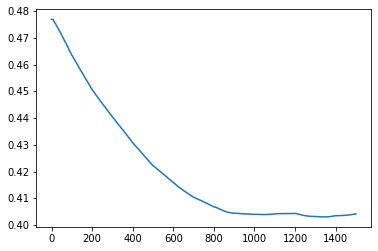

In [61]:
fig = plt.figure()
plt.plot(f_ClippSQN)

In [70]:
'''
    Stochastic Quasi-Newton method
'''
lambda_m = 0.5
x_SQN, f_SQN = SQN(objFunc, x_start, H_start, int(10), K, L_0, lambda_m, lambda_M, epsilon)

In [22]:
'''
    SGD
'''
x_SGD, f_SGD = minibatch_SGD(objFunc, x_start, int(10), K, L_0, epsilon)

In [67]:
'''
    Spider
'''
x_Spider, f_Spider = Spider(objFunc, x_start, batch_S1, batch_S2, K, r, L_0, epsilon, 1.2)

In [27]:
'''
    Clipped Spider
'''
x_ClipSpider, f_ClipSpider = Clipped_Spider(objFunc, x_start, batch_S1, batch_S2, K, r, L_0, L_1, epsilon)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


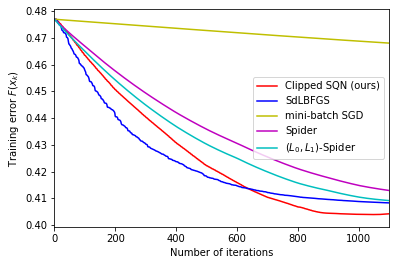

In [112]:
plt.plot(f_ClippSQN, 'r')
plt.plot(f_SQN, 'b')
plt.plot(f_SGD, 'y')
plt.plot(f_Spider, 'm')
plt.plot(f_ClipSpider, 'c')
plt.xlim([0, 1100])
plt.legend(['Clipped SQN (ours)', 'SdLBFGS', 'mini-batch SGD','Spider', '$(L_0, L_1)$-Spider'])
plt.xlabel('Number of iterations')
plt.ylabel('Training error $F(x_k)$')
plt.savefig('robustLR_training_loss_3.eps')

In [151]:
class NC_logistic_regression:
    '''
        Consider the non-convex logistic regression problem.
        
        f(x) = 1 / n sum(l(b_i, a_i^T x)), where l(x, y) = x * log(y) + y * log(x) + 0.1 * sum(x_j^2 / (1 + x_j^2))
    '''
    def __init__(self, data):
        # data structure is 2d narray, where each row is one data point and the last column is the label
        self.data = data
        self.n = data.shape[0]
        self.dim = data.shape[1] - 1
        self.A = data[:, :-1]
        self.b = data[:, -1:]
        
    def func_value(self, x):
        n = self.n
        A = self.A
        b = self.b
        sum_loss = 0
        for i in range(n):
            a_i = A[i, :]
            b_i = b[i, :]
            sum_loss = sum_loss + b_i * np.log(1.0 / (1.0 + np.exp(-np.dot(a_i, x)))) + (2 - b_i) * np.log(1.0 / (1.0 + np.exp(np.dot(a_i, x)))) # + 0.2 * np.sum(x * x / (1.0 + x * x)) / n
        return -sum_loss / n
    
    def full_gradient(self, x):
        dfdx = autograd.grad(self.func_value)
        return dfdx(x)
    
    def sample_gradient(self, x_eval):
        n = self.n
        A = self.A
        b = self.b
        gradient_list = []
        for i in range(n):
            a_i = A[i, :]
            b_i = b[i, :]
            sample_loss = lambda x: -b_i * np.log(1.0 / (1.0 + np.exp(-np.dot(a_i, x)))) - (2 - b_i) * np.log(1.0 / (1.0 + np.exp(np.dot(a_i, x)))) # + 0.2 * np.sum(x * x / (1.0 + x * x)) / n
            gradient_i = autograd.grad(sample_loss)
            gradient_i_eval = gradient_i(x_eval)
            gradient_list.append(gradient_i_eval)
            
        return gradient_list
    
    def batch_gradient(self, x, batch_size):
        '''
            return the list of mini-batch gradients evaluated at point x with the batch-size = batch_size
        '''
        n = self.n
        gradient_list = self.sample_gradient(x)
        all_gradients = np.asarray(gradient_list)
        # generate shuffled data
        permutation = list(np.random.permutation(self.n))
        shuffled_gradients = all_gradients[permutation, :]
        
        num_batches = math.floor(self.n / batch_size)
        
        mini_batches = []
        for i in range(num_batches):
            mini_batch_grad = shuffled_gradients[i * batch_size:(i + 1) * batch_size, :]
            mini_batches.append(mini_batch_grad)
            
        if n % batch_size != 0:
            mini_batches.append(shuffled_gradient[num_batches * batch_size:, :])
            
        return mini_batches
    
    def minibatch_grad(self, x_eval, batch_size, batch_i):
        # return the mini-batch gradient evaluated at x_eval with the i-th batch
        n = self.n
        all_gradients = np.asarray(self.sample_gradient(x_eval))
        
        batch_grad = all_gradients[batch_i * batch_size:(batch_i + 1) * batch_size, :]
        curr_minibatch_grad = np.sum(batch_grad, axis=0) / batch_grad.shape[0]
        return curr_minibatch_grad

In [128]:
class NC_SVM:
    '''
        Consider the non-convex SVM.
        
        f(x) = 1 / n sum(1 - tanh(bi * ai^T x) + t x^T x / n),
    '''
    def __init__(self, data):
        # data structure is 2d narray, where each row is one data point and the last column is the label
        self.data = data
        self.n = data.shape[0]
        self.dim = data.shape[1] - 1
        self.A = data[:, :-1]
        self.b = data[:, -1:]
        
    def func_value(self, x):
        n = self.n
        A = self.A
        b = self.b
        sum_loss = 0
        for i in range(n):
            a_i = A[i, :]
            b_i = b[i, :]
            sum_loss = sum_loss + (1 - np.tanh(b_i * np.dot(a_i, x))) + 0.1 * np.dot(x, x) / n
        return sum_loss / n
    
    def full_gradient(self, x):
        dfdx = autograd.grad(self.func_value)
        return dfdx(x)
    
    def sample_gradient(self, x_eval):
        n = self.n
        A = self.A
        b = self.b
        gradient_list = []
        for i in range(n):
            a_i = A[i, :]
            b_i = b[i, :]
            sample_loss = lambda x: (1 - np.tanh(b_i * np.dot(a_i, x))) + 0.1 * np.dot(x, x) / n
            gradient_i = autograd.grad(sample_loss)
            gradient_i_eval = gradient_i(x_eval)
            gradient_list.append(gradient_i_eval)
            
        return gradient_list
    
    def batch_gradient(self, x, batch_size):
        '''
            return the list of mini-batch gradients evaluated at point x with the batch-size = batch_size
        '''
        n = self.n
        gradient_list = self.sample_gradient(x)
        all_gradients = np.asarray(gradient_list)
        # generate shuffled data
        permutation = list(np.random.permutation(self.n))
        shuffled_gradients = all_gradients[permutation, :]
        
        num_batches = math.floor(self.n / batch_size)
        
        mini_batches = []
        for i in range(num_batches):
            mini_batch_grad = shuffled_gradients[i * batch_size:(i + 1) * batch_size, :]
            mini_batches.append(mini_batch_grad)
            
        if n % batch_size != 0:
            mini_batches.append(shuffled_gradient[num_batches * batch_size:, :])
            
        return mini_batches
    
    def minibatch_grad(self, x_eval, batch_size, batch_i):
        # return the mini-batch gradient evaluated at x_eval with the i-th batch
        n = self.n
        all_gradients = np.asarray(self.sample_gradient(x_eval))
        
        batch_grad = all_gradients[batch_i * batch_size:(batch_i + 1) * batch_size, :]
        curr_minibatch_grad = np.sum(batch_grad, axis=0) / batch_grad.shape[0]
        return curr_minibatch_grad

In [129]:
abc = np.array([2, 3])
np.sum(abc * abc / (abc * abc + 1))

1.7000000000000002

In [152]:
objFunc_NClog = NC_logistic_regression(data_syn)

In [153]:
objFunc_NClog.func_value(x_start)

array([1.62677621])

In [172]:
H_start = 0.1 * np.eye(dim)
h_c = 1.0
lambda_M = 5
batch_S1 = 1000
batch_S2 = 200
r = math.ceil(1 / epsilon)
L_0 = 5.0
L_1 = 1.0
# K = math.ceil(2 * L_0 * lambda_M**2 * 2 / ((epsilon * h_c)**2))
K = int(1500)

x_ClippSQN_log, f_ClippSQN_log = clipped_SQN(objFunc_NClog, x_start, H_start, batch_S1, batch_S2, K, r, L_0, L_1, epsilon, h_c, lambda_M)


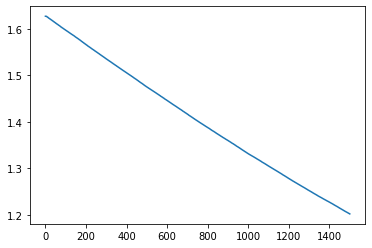

In [173]:
plt.plot(f_ClippSQN_log)

In [188]:
'''
    Stochastic Quasi-Newton method
'''
lambda_m = 0.5
x_SQN_log, f_SQN_log = SQN(objFunc_NClog, x_start, H_start, int(10), K, L_0, lambda_m, lambda_M, 3 * epsilon)

In [175]:
'''
    SGD
'''
x_SGD_log, f_SGD_log = minibatch_SGD(objFunc_NClog, x_start, int(10), K, L_0, 0.1 * epsilon)

In [176]:
'''
    Spider
'''
x_Spider_log, f_Spider_log = Spider(objFunc_NClog, x_start, batch_S1, batch_S2, K, r, L_0, 0.1 * epsilon, 1.2)

In [177]:
'''
    Clipped Spider
'''
x_ClipSpider_log, f_ClipSpider_log = Clipped_Spider(objFunc_NClog, x_start, batch_S1, batch_S2, K, r, L_0, L_1, 0.1 * epsilon)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


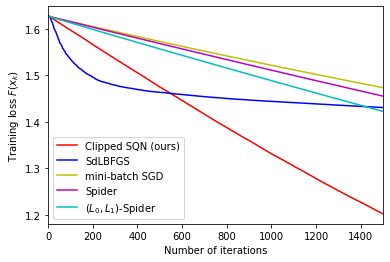

In [189]:
plt.plot(f_ClippSQN_log, 'r')
plt.plot(f_SQN_log, 'b')
plt.plot(f_SGD_log, 'y')
plt.plot(f_Spider_log, 'm')
plt.plot(f_ClipSpider_log, 'c')
plt.xlim([0, K])
plt.legend(['Clipped SQN (ours)', 'SdLBFGS', 'mini-batch SGD','Spider', '$(L_0, L_1)$-Spider'])
plt.xlabel('Number of iterations')
plt.ylabel('Training loss $F(x_k)$')
plt.savefig('NC_logistic_training_loss_3.eps')